# Denoising Diffusion Probabilistic Model Notebook

In this notebook i tried to give you complete access to DDPMs. 
https://arxiv.org/pdf/2006.11239

You should be able to train a little model to generate pixelated celebrities faces.

In the notebook you 'll find options to load the CIFAR10 dataset with all the classes or with only one, as well as the CelebA-HQ dataset.:
(For a conditional generation with CIFAR10 I advice to train it more and with lot of parameters since the provided model is very simple and struggle with different classesQ)

- Mario Prignano

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import math


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## CIFAR10

In [2]:
# This is a generic Transform from torchvision
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


def get_single_class_cifar10(class_idx=0):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    indices = [i for i, (_, label) in enumerate(dataset) if label == class_idx]
    return Subset(dataset, indices)

train_dataset = get_single_class_cifar10(7)
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) # uncomment this if you want to load all 10 classes

## CELEBA HQ

In [2]:
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, v2, Resize, Normalize
import matplotlib.pyplot as plt
import numpy as np
import os

H,W = 32,32   # 32x32 is the default, but if the model is powerful enough you can train up to 256x256!

transform2 = v2.Compose([
    v2.ToDtype(torch.float32),
    v2.RandomHorizontalFlip(p=0.5), 
    Resize(size=(H,W)),
    Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]) 
])

class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root = root_dir
        self.imgs = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        path = os.path.join(self.root, self.imgs[idx])
        img = read_image(path, mode=ImageReadMode.RGB)    
        img = img.float().div(255.0) 
        if self.transform is not None:
            img = self.transform(img)
        return img
        
train_dataset = CelebADataset("/kaggle/input/celebahq-resized-256x256/celeba_hq_256", transform=transform2)

## Always have a look at the dataset!

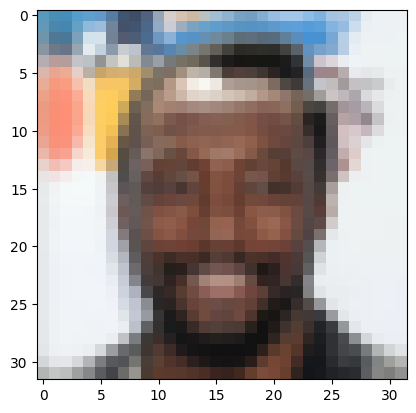

In [3]:
img = next(iter(train_dataset)) # this checks if 
if isinstance(img, tuple):          
    plt.imshow( next(iter(train_dataset))[0].permute(1, 2, 0) * 0.5 + 0.5)   # the * 0.5 + 0.5 term is just inverting the normalization
else:
    plt.imshow( next(iter(train_dataset)).permute(1, 2, 0) * 0.5 + 0.5)

plt.show()

# Diffusion

## Constants & Utils

In [4]:
T = 400
beta_start = 1e-4
beta_end   = 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)  

alphas = 1. - betas                                                      
alphas_cumprod = torch.cumprod(alphas, dim=0)                            
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)        

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)                         
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)            

posterior_mean_coef1 = betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)
posterior_mean_coef2 = (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# Diffusion Functions
a slightly modified version of: https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/simple_diffusion.py to introduce conditionality

Here label is supposed to be a tensor of longs, conditioning the generation to a class, only possible with CIFAR10 full dataset. If you have a single class you can just use label = label*0

In [5]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(0, t)
    return out.reshape(batch_size, *([1] * (len(x_shape) - 1)))

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    return extract(sqrt_alphas_cumprod, t, x_start.shape) * x_start + \
           extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise


def q_posterior(x_start, x_t, t):
    coef1 = extract(posterior_mean_coef1, t, x_t.shape)
    coef2 = extract(posterior_mean_coef2, t, x_t.shape)
    posterior_mean = coef1 * x_start + coef2 * x_t
    posterior_log_variance = torch.log(extract(posterior_variance, t, x_t.shape))
    return posterior_mean, posterior_log_variance
    
def p_sample(model, x_t, t, label):
    eps_pred = model(x_t, t, label)
    x0_pred = (
        x_t - extract(sqrt_one_minus_alphas_cumprod, t, x_t.shape) * eps_pred
    ) / extract(sqrt_alphas_cumprod, t, x_t.shape)
    x0_pred = torch.clamp(x0_pred, -1., 1.)

    mean, log_var = q_posterior(x0_pred, x_t, t)
    noise = torch.randn_like(x_t) if t[0] > 0 else torch.zeros_like(x_t)
    return mean + noise * torch.exp(0.5 * log_var)

def p_sample_loop(model, shape, label):
    x_t = torch.randn(shape, device=device)
    for i in reversed(range(T)):
        t = torch.full((shape[0],), i, device=device, dtype=torch.long)
        x_t = p_sample(model, x_t, t, label)
    return x_t


def p_losses(model, x_start, t, label, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    x_noisy = q_sample(x_start, t, noise)
    eps_pred = model(x_noisy, t, label)
    return F.l1_loss(eps_pred, noise)

# A very simple UNet implementation
Here's a UNet with Residual Blocks and 3 levels of downpooling.
Feel free to play with the model.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels*3, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        q, k, v = self.qkv(self.norm(x)).chunk(3, dim=1)
        q = q.view(B, C, -1).permute(0, 2, 1)
        k = k.view(B, C, -1)
        v = v.view(B, C, -1)
        
        attn = torch.bmm(q, k) * (C ** -0.5)
        attn = F.softmax(attn, dim=-1)
        out = torch.bmm(v, attn.permute(0, 2, 1))
        return x + self.proj_out(out.view(B, C, H, W))
        
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.exp(-torch.arange(half_dim, dtype=torch.float32, device=device) * (math.log(10000) / (half_dim - 1)))
        emb = t[:, None].float() * emb[None, :]
        return torch.cat([emb.sin(), emb.cos()], dim=-1)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.time_emb_proj = nn.Linear(time_emb_dim, out_channels)
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU()
        )
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        h += self.time_emb_proj(t_emb)[:, :, None, None]
        h = self.block2(h)
        return h + self.residual_conv(x)

class UNet(nn.Module):
    def __init__(self, num_classes=10, base_channels=64):
        super().__init__()
        time_emb_dim = base_channels * 4

        self.time_embedding = nn.Sequential(
            SinusoidalPosEmb(base_channels),
            nn.Linear(base_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        self.label_embedding = nn.Embedding(num_classes, time_emb_dim)

        self.down1 = ResidualBlock(3, base_channels, time_emb_dim)
        self.down2 = ResidualBlock(base_channels, base_channels * 2, time_emb_dim)
        self.down3 = ResidualBlock(base_channels * 2, base_channels * 4, time_emb_dim)

        self.pool = nn.AvgPool2d(2)

        self.mid = ResidualBlock(base_channels * 4, base_channels * 4, time_emb_dim)

        self.up3 = ResidualBlock(base_channels * 8, base_channels * 2, time_emb_dim)
        self.up2 = ResidualBlock(base_channels * 4, base_channels, time_emb_dim)
        self.up1 = ResidualBlock(base_channels * 2, base_channels, time_emb_dim)

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.mid_att = AttentionBlock(base_channels*4) 
        
        self.out =  nn.Conv2d(base_channels, 3, 1)
        nn.init.zeros_(self.out.weight) 
        
    def forward(self, x, t, y):
        t_emb = self.time_embedding(t)
        y_emb = self.label_embedding(y)
        temb = t_emb + y_emb

        x1 = self.down1(x, temb)
        x2 = self.down2(self.pool(x1), temb)
        x3 = self.down3(self.pool(x2), temb)

        x_mid = self.mid(self.pool(x3), temb)
        # x_mid = self.mid_att(x_mid)

        u3 = self.up3(torch.cat([self.upsample(x_mid), x3], dim=1), temb)
        u2 = self.up2(torch.cat([self.upsample(u3), x2], dim=1), temb)
        u1 = self.up1(torch.cat([self.upsample(u2), x1], dim=1), temb)

        return self.out(u1)

# Model and optimization

In [7]:
model = UNet(10, 32*5).to(device) # here we create the Unet with 10 classes (needed for the conditional CIFAR10) and 224 base channels
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # this counts all the parameters
# model = torch.nn.DataParallel(model) # uncomment this if you want to train with more than one GPU
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4) # this creates the optimizer, i choose AdamW since is a good starting point
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
print(f"Number of parameters: {pytorch_total_params:,}")

Number of parameters: 25,507,363


In [8]:
from tqdm import tqdm
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=4) # You can experiment with batch size and learning rate so i left the dataloader here for simplicity
# For reference you can obtain some cool results with 0.13 / 0.11 of loss even if its pretty high!
# For good results with this model you must wait more and increase the parameters. Also put attention, one or more in the latent (one is already there but commented)
# Another thing you can try to have better results with more time is a bigger batch size and lower lr, as well as an interpolation between l1 loss and l2 loss in the p_loss()

print(f"dataloader entries: {len(train_loader)}")
for epoch in range(4): #  Number of epochs
    model.train()
    total_loss = 0.0
    # for step, (x, label) in enumerate(tqdm(train_loader)): # UNCOMMENT AND USE THIS FOR CONDITIONAL CIFAR10
    for step, x in enumerate(tqdm(train_loader)):
        x = x.to(device)
        label = torch.tensor([0 for _ in range(x.shape[0])], device=device) # label.to(device) # FOR UNCONDITIONAL DATAS I PUT ALL THE LABELS AT 0
        batch_size = x.shape[0]
        t = torch.randint(0, T, (batch_size,), device=device).long()

        with torch.amp.autocast('cuda'):
            loss = p_losses(model, x, t, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        if step % 100 == 0: # This is a sort of verbose that happens every 100 steps
            print(f"Epoch {epoch} | Step {step} | Loss {loss.item():.4f}")

    avg = total_loss / len(train_loader)
    print(f"Epoch {epoch} completed. Avg Loss: {avg:.4f}")

dataloader entries: 1875


  0%|          | 4/1875 [00:01<09:38,  3.23it/s]

Epoch 0 | Step 0 | Loss 0.7963


  6%|▌         | 104/1875 [00:06<01:21, 21.73it/s]

Epoch 0 | Step 100 | Loss 0.1544


 11%|█         | 203/1875 [00:11<01:19, 21.02it/s]

Epoch 0 | Step 200 | Loss 0.2085


 16%|█▌        | 302/1875 [00:15<01:18, 19.97it/s]

Epoch 0 | Step 300 | Loss 0.1478


 22%|██▏       | 404/1875 [00:20<01:11, 20.71it/s]

Epoch 0 | Step 400 | Loss 0.1505


 27%|██▋       | 503/1875 [00:25<01:08, 19.95it/s]

Epoch 0 | Step 500 | Loss 0.1404


 32%|███▏      | 605/1875 [00:29<00:54, 23.33it/s]

Epoch 0 | Step 600 | Loss 0.1261


 38%|███▊      | 704/1875 [00:34<00:51, 22.79it/s]

Epoch 0 | Step 700 | Loss 0.1705


 43%|████▎     | 803/1875 [00:39<00:51, 20.69it/s]

Epoch 0 | Step 800 | Loss 0.1994


 48%|████▊     | 902/1875 [00:44<00:51, 18.82it/s]

Epoch 0 | Step 900 | Loss 0.2123


 54%|█████▎    | 1004/1875 [00:49<00:39, 22.31it/s]

Epoch 0 | Step 1000 | Loss 0.1721


 59%|█████▉    | 1103/1875 [00:53<00:36, 21.39it/s]

Epoch 0 | Step 1100 | Loss 0.1509


 64%|██████▍   | 1205/1875 [00:58<00:29, 22.52it/s]

Epoch 0 | Step 1200 | Loss 0.2105


 70%|██████▉   | 1304/1875 [01:02<00:26, 21.19it/s]

Epoch 0 | Step 1300 | Loss 0.1536


 75%|███████▍  | 1403/1875 [01:07<00:22, 21.33it/s]

Epoch 0 | Step 1400 | Loss 0.1419


 80%|████████  | 1505/1875 [01:12<00:16, 22.93it/s]

Epoch 0 | Step 1500 | Loss 0.1172


 86%|████████▌ | 1604/1875 [01:16<00:12, 21.29it/s]

Epoch 0 | Step 1600 | Loss 0.1470


 91%|█████████ | 1703/1875 [01:21<00:07, 22.19it/s]

Epoch 0 | Step 1700 | Loss 0.1745


 96%|█████████▋| 1805/1875 [01:26<00:03, 23.18it/s]

Epoch 0 | Step 1800 | Loss 0.1446


100%|██████████| 1875/1875 [01:29<00:00, 21.01it/s]


Epoch 0 completed. Avg Loss: 0.1617


  0%|          | 1/1875 [00:00<05:19,  5.86it/s]

Epoch 1 | Step 0 | Loss 0.1693


  6%|▌         | 106/1875 [00:03<01:01, 28.66it/s]

Epoch 1 | Step 100 | Loss 0.1132


 11%|█         | 205/1875 [00:07<00:57, 28.89it/s]

Epoch 1 | Step 200 | Loss 0.1588


 16%|█▌        | 304/1875 [00:10<00:55, 28.42it/s]

Epoch 1 | Step 300 | Loss 0.1548


 22%|██▏       | 406/1875 [00:14<00:51, 28.76it/s]

Epoch 1 | Step 400 | Loss 0.1778


 27%|██▋       | 505/1875 [00:17<00:47, 28.93it/s]

Epoch 1 | Step 500 | Loss 0.1463


 32%|███▏      | 604/1875 [00:21<00:44, 28.83it/s]

Epoch 1 | Step 600 | Loss 0.1387


 38%|███▊      | 706/1875 [00:24<00:40, 28.75it/s]

Epoch 1 | Step 700 | Loss 0.1611


 43%|████▎     | 805/1875 [00:28<00:37, 28.77it/s]

Epoch 1 | Step 800 | Loss 0.1423


 48%|████▊     | 904/1875 [00:31<00:33, 28.79it/s]

Epoch 1 | Step 900 | Loss 0.1554


 54%|█████▎    | 1006/1875 [00:35<00:30, 28.86it/s]

Epoch 1 | Step 1000 | Loss 0.1482


 59%|█████▉    | 1105/1875 [00:38<00:26, 28.73it/s]

Epoch 1 | Step 1100 | Loss 0.1332


 64%|██████▍   | 1204/1875 [00:41<00:23, 28.24it/s]

Epoch 1 | Step 1200 | Loss 0.1238


 70%|██████▉   | 1306/1875 [00:45<00:19, 28.89it/s]

Epoch 1 | Step 1300 | Loss 0.1670


 75%|███████▍  | 1405/1875 [00:48<00:16, 28.51it/s]

Epoch 1 | Step 1400 | Loss 0.1291


 80%|████████  | 1504/1875 [00:52<00:12, 28.96it/s]

Epoch 1 | Step 1500 | Loss 0.1227


 86%|████████▌ | 1606/1875 [00:55<00:09, 28.85it/s]

Epoch 1 | Step 1600 | Loss 0.1671


 91%|█████████ | 1705/1875 [00:59<00:05, 28.90it/s]

Epoch 1 | Step 1700 | Loss 0.1232


 96%|█████████▌| 1804/1875 [01:02<00:02, 28.86it/s]

Epoch 1 | Step 1800 | Loss 0.1750


100%|██████████| 1875/1875 [01:05<00:00, 28.76it/s]


Epoch 1 completed. Avg Loss: 0.1408


  0%|          | 1/1875 [00:00<05:12,  6.00it/s]

Epoch 2 | Step 0 | Loss 0.1249


  6%|▌         | 106/1875 [00:03<01:00, 29.02it/s]

Epoch 2 | Step 100 | Loss 0.1448


 11%|█         | 205/1875 [00:07<00:57, 28.95it/s]

Epoch 2 | Step 200 | Loss 0.1581


 16%|█▌        | 304/1875 [00:10<00:54, 28.90it/s]

Epoch 2 | Step 300 | Loss 0.1318


 22%|██▏       | 406/1875 [00:14<00:50, 28.98it/s]

Epoch 2 | Step 400 | Loss 0.1290


 27%|██▋       | 505/1875 [00:17<00:47, 28.98it/s]

Epoch 2 | Step 500 | Loss 0.1181


 32%|███▏      | 604/1875 [00:21<00:43, 28.98it/s]

Epoch 2 | Step 600 | Loss 0.1290


 34%|███▍      | 644/1875 [00:22<00:43, 28.58it/s]


KeyboardInterrupt: 

### This Cleans up the ram and vram, use it if working with big model > 50mln parameters

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

## CIFAR-10 Dataset Classes and their corresponding integer labels for Conditional Generation:

Label | Class Name
------|-----------
0     | airplane
1     | automobile
2     | bird
3     | cat
4     | deer
5     | dog
6     | frog
7     | horse
8     | ship
9     | truck

tensor(0.5618, device='cuda:0') tensor(0.2308, device='cuda:0')


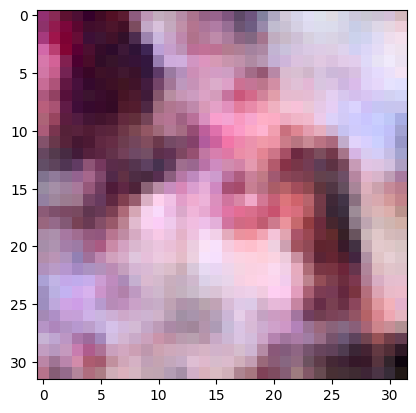

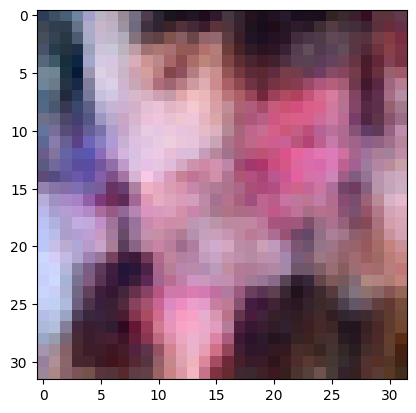

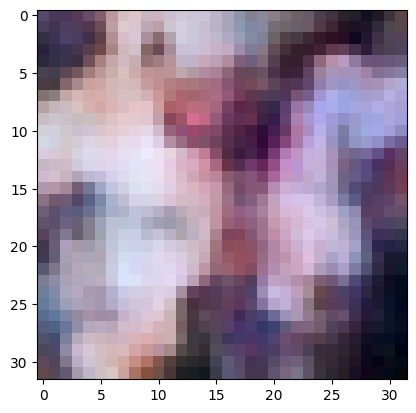

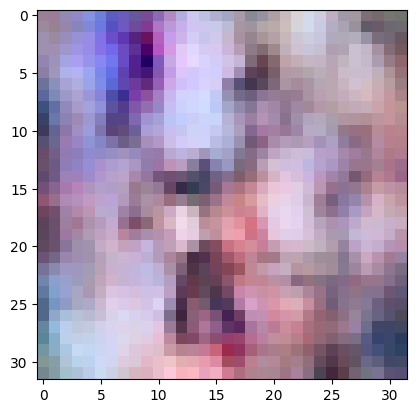

In [53]:
import matplotlib.pyplot as plt

with torch.no_grad():
    samples = p_sample_loop(model, (4, 3, H, W), label=torch.tensor([7, 7, 7, 7], device=device)*0) # Remember to put *0 here if you want to use
    samples = (samples/2) + 0.5
    print(samples.mean(), samples.std())
    for i in range(len(samples)):
        plt.imshow(samples[i].permute(1, 2, 0).cpu())
        plt.show()

# Unconditional Generation, Use this for Celeb

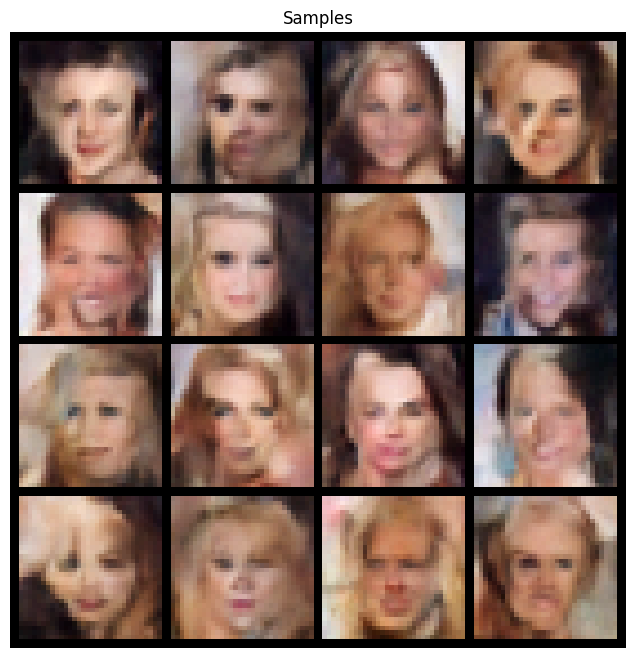

In [9]:
model.eval()

with torch.no_grad():
    batch_size = 16
    labels = torch.randint(0, 10, (batch_size,), device=device)*0
    samples = p_sample_loop(model, (batch_size, 3, H, W), labels)

samples = samples * 0.5 + 0.5
samples = torch.clamp(samples, 0., 1.)

import matplotlib.pyplot as plt
import torchvision.utils as vutils

grid = vutils.make_grid(samples.cpu(), nrow=4)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Samples")
plt.imshow(grid.permute(1, 2, 0))
plt.show()

### Hope you had good results :)